# Model 1 - Recurrent neural network (RNN) using only the kinematic features.

In [74]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./src')
from data_utils import *
clear_output(wait=False)

### Load train, validation and test data

In [75]:
user_train, user_val, user_test = train, val, test = train_test_data_split()

In [76]:
data_train = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_train]).reset_index(drop=True)
data_val = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_val]).reset_index(drop=True)
data_test = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_test]).reset_index(drop=True)

#### Example input data

In [77]:
data_train[data_train['segment_point_count'] >= 6].head(6)

,user,ts,x,y,label,image_ix,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
44,8,2018-06-19 11:19:21,720902.529966,6.187934e+06,0,632,138.0,71.906582,2.382204,0.521062,2,43,0,7
45,8,2018-06-19 11:20:16,720939.552159,6.187975e+06,0,633,55.0,55.503567,0.840590,1.009156,2,43,1,7
46,8,2018-06-19 11:21:12,720881.561210,6.188045e+06,0,634,56.0,90.421608,2.267039,1.614672,2,43,2,7
47,8,2018-06-19 11:22:07,720874.984099,6.188093e+06,0,635,55.0,48.346900,1.707259,0.879035,2,43,3,7
48,8,2018-06-19 11:22:59,720927.287216,6.188142e+06,0,636,52.0,71.568118,0.751280,1.376310,2,43,4,7
49,8,2018-06-19 11:23:02,720903.916798,6.188161e+06,0,637,3.0,30.552280,2.441732,10.184093,2,43,5,7


#### Numer of training data points

In [78]:
len(data_train[data_train['segment_point_count'] >= 6])

1156467

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [142]:
def create_dataset(df):
    seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(5, -1, -1)], axis = 1)
    seq = seq[df['segment_ix'] >= 5]
    
    #tod = np.stack([np.roll(df['ts'].dt.hour.values, i, axis = 0) for i in range(6)], axis = 1)    
    tod = df.loc[df['segment_ix'] >= 5, 'tod'].values
    tod_one_hot = np.eye(5)[tod]    
    
    #target = np.stack([np.roll(df['label'].values, i, axis = 0) for i in range(6)], axis = 1)
    target = df.loc[df['segment_ix'] >= 5, 'label'].values
    
    return torch.utils.data.TensorDataset(torch.Tensor(seq), torch.Tensor(tod_one_hot), torch.LongTensor(target))

## Example Input/output data from ``TensorDataset``

In [143]:
demo_dataset = create_dataset(data_train)

for X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=3, shuffle=True):
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break

X_seq : torch.Size([3, 6, 2])
tensor([[ 3.2272e+01, -2.2767e-02],
        [ 3.1733e+01,  3.3175e-02],
        [ 3.3404e+01,  1.2880e-01],
        [ 3.1641e+01,  2.6400e-01],
        [ 3.2044e+01,  2.9528e-01],
        [ 3.5251e+01,  3.6128e-01]])
X_tod : torch.Size([3, 5])
tensor([0., 0., 0., 0., 1.])
y : torch.Size([3])
tensor(0)


### Hyper Parameters

In [144]:
# Network Parameters
SEQ_LENGTH = 6
SEQ_FEATURES = 2
TOD_INPUT_DIM = 5
RNN_HIDDEN_DIM = 4
RNN_NUM_LAYERS = 2
RNN_BIDIRECT = False

NUM_CLASSES = 2

# Training Parameters
NUM_EPOCH = 40
BATCH_SIZE = 12000
DROPOUT_PROP = .20
LEARNING_RATE = 0.1
LEARNING_DECAY_FACTOR = 0.1
LEARNING_DECAY_EPOCHS = [35]

#### Define Data Loaders

In [145]:
train_dataloader = torch.utils.data.DataLoader(create_dataset(data_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(create_dataset(data_val), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(create_dataset(data_test), batch_size=BATCH_SIZE, shuffle=True)

#### How many data points are lost due to building sequences?

In [146]:
print(f'{1 - len(create_dataset(data_train)) / len(data_train):.2%}')

2.92%


In [147]:
def adjust_lr(optimizer, epoch):
    number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
    lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [163]:
class RnnNet(nn.Module):

    def __init__(self):
        super(RnnNet, self).__init__()
        
        rnn_output_dim = SEQ_LENGTH*RNN_HIDDEN_DIM
        if RNN_BIDIRECT:
            rnn_output_dim *= 2
        hfc = 256 * 2
        hfc8 = hfc // 5
        
        self.DO = nn.Dropout(DROPOUT_PROP)    
        
        self.BNgru_0_K = nn.BatchNorm1d(SEQ_LENGTH)
        self.rnn_1_1 = nn.GRU(SEQ_FEATURES, RNN_HIDDEN_DIM, RNN_NUM_LAYERS, batch_first=True, bidirectional=RNN_BIDIRECT)
        self.BNgru_1_1 = nn.BatchNorm1d(RNN_HIDDEN_DIM * SEQ_LENGTH)
                            
        self.fc_out_1 = nn.Linear(rnn_output_dim + TOD_INPUT_DIM, hfc)
        
        self.BNFC_hfc_out_1 = nn.BatchNorm1d(hfc)
        
        self.fc_out_2 = nn.Linear(hfc, hfc8)
        
        self.BNFC_hfc_out_2 = nn.BatchNorm1d(hfc8)
                
        self.l_out = nn.Linear(in_features=hfc8, out_features=NUM_CLASSES, bias=False)

    def forward(self, x_seq, x_tod):
        features = []
        """        
        out = {}
        x_fuse = torch.cat([x_dist.unsqueeze(1),x_br.unsqueeze(1)],dim=1)
        x_fuse=self.BNgru_0_K(x_fuse)
        
        x_fuse = x_fuse.unsqueeze(2)
        #print('7',x_fuse.shape)
        x_fuse = x_fuse.reshape(sequence_size, -1, x_fuse.shape[1])
        #print('8',x_fuse.shape)
        
        #input of shape (seq_len, batch, input_size)
        x_fuse, h_img = self.rnn_1_1(x_fuse)
        #print('9',x_fuse.shape)
        
        x_fuse = x_fuse.reshape(int(x_fuse.shape[1]*x_fuse.shape[0]), -1)
        #print('10',x_fuse.shape)
        
        x_fuse = self.DO(self.BNgru_1_1(relu(x_fuse)))
        #print('11',x_fuse.shape)
        
        features.append(x_fuse)
        
        #>>>>> x_dTS <<<<<#
        #print('ToD******** 1 ',x_dTS.shape)
        x_dTS = self.BNgru_0_TS(x_dTS)       
        #print('ToD******** 2 ',x_dTS.shape)
        features.append(x_dTS)
        
        ## Output layer where all features are in use ##
        #print('12',features[0].shape, features[1].shape)
        features_final = torch.cat(features, dim=1)
        #print('13',features_final.shape)
        features_final = self.BNFC_hfc_out_0(features_final)
        #print('14',features_final.shape)
        features_final = self.DO(self.BNFC_hfc_out_1(relu(self.fc_out_1(features_final))))
        #print('15',features_final.shape)
        features_final = self.DO(self.BNFC_hfc_out_2(relu(self.fc_out_2(features_final))))
        #print('16',features_final.shape)
        #out = log_softmax(self.l_out(features_final), dim=1) 
        out = softmax(self.l_out(features_final), dim=1) 
        #print('17',self.l_out(features_final).shape)
        return out
        """        
        
        # x_seq #
        x_seq = self.BNgru_0_K(x_seq)   
        
        # x_seq : (batch, seq_lenth, seq_features)                              
        x_seq = x_seq.permute(1, 0, 2)        
        # x_seq : (seq_lenth, batch, seq_features)
                
        x_seq, h_n = self.rnn_1_1(x_seq)
        # x_seq : (seq_len, batch, num_directions * hidden_size):
        # h_n : (num_layers * num_directions, batch, hidden_size)

        x_seq = x_seq.permute(1, 0, 2)
        # x_seq : (batch, seq_lenth, num_directions * hidden_size)
        x_seq = x_seq.flatten(start_dim = 1)
        x_seq = self.BNgru_1_1(x_seq)
        x_seq = F.relu(x_seq)        
        x_seq = self.DO(x_seq)
        
        features.append(x_seq)
        
        # x_tod #
        x_tod = x_tod
        features.append(x_tod)
        
        ## Output layer where all features are in use ##
        
        features_final = torch.cat(features, dim=1)
        features_final = features_final.contiguous().view(features_final.shape[0], -1)
        
        #features_final = self.BNFC_hfc_out_0(features_final)
        
        features_final = self.DO(F.relu(self.BNFC_hfc_out_1(self.fc_out_1(features_final))))
        
        features_final = self.DO(F.relu(self.BNFC_hfc_out_2(self.fc_out_2(features_final))))
        
        out = self.l_out(features_final)
        #out = out.view(features_final.shape[0], self.seq_length, self.output_dim)        
        out = F.softmax(out, dim=1) 
        
        
        return out

#### Define class weights due to large class im-balance

In [164]:
class_weights = [(data_train['label'] == 0).sum()/(data_train['label'] == x).sum() for x in range(NUM_CLASSES)]
class_weights

[1.0, 0.36125205657481785]

#### Define model, optimizer and loss

In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = RnnNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).to(device))

#### Number of parameters

In [166]:
np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

69394

#### Test input/output of model

In [167]:
out = model(X_seq.to(device), X_tod.to(device))
print(out.shape)

torch.Size([3, 2])


In [168]:
out[:2].cpu()

tensor([[0.3423, 0.6577],
        [0.6698, 0.3302]], grad_fn=<CopyBackwards>)

In [169]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    },
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

### Train / Validation loop

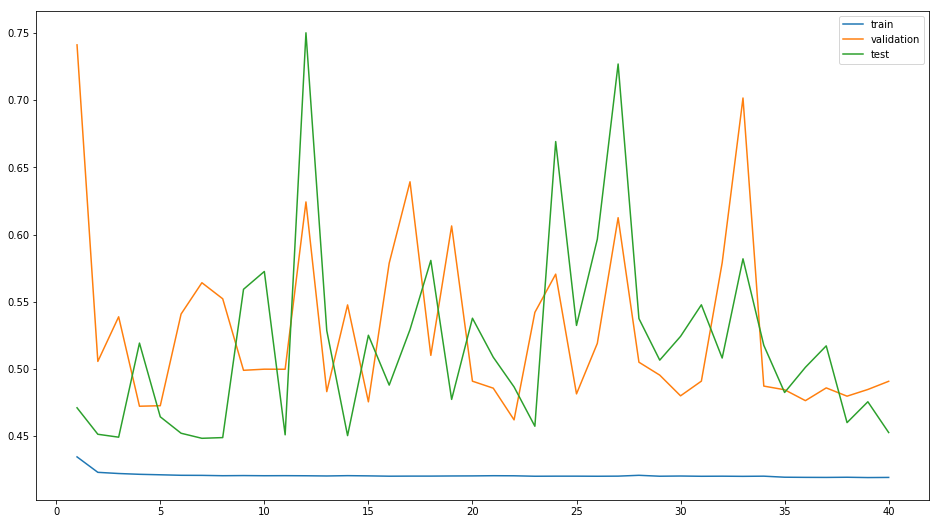

In [170]:
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            X_seq, X_tod, y = batch

            X_seq = X_seq.to(device)
            X_tod = X_tod.to(device)
            y = y.to(device)

            with torch.set_grad_enabled(phase_is_training):
                out = model(X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.5)
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();            

### Validation/Test prediction loop

In [171]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_seq, X_tod, y = batch

        phase['true'].extend(list(y.numpy()))
        
        X_seq = X_seq.to(device)
        X_tod = X_tod.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            out = model(X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            correct = (predicted == y).cpu().numpy()
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))        

### Final results

In [172]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop']))

validation
              precision    recall  f1-score   support

      Motion       0.75      0.79      0.77     43215
        Stop       0.87      0.84      0.86     72334

   micro avg       0.82      0.82      0.82    115549
   macro avg       0.81      0.82      0.81    115549
weighted avg       0.83      0.82      0.82    115549

test
              precision    recall  f1-score   support

      Motion       0.66      0.86      0.74     42425
        Stop       0.94      0.85      0.89    122881

   micro avg       0.85      0.85      0.85    165306
   macro avg       0.80      0.85      0.82    165306
weighted avg       0.87      0.85      0.85    165306

